<a href="https://colab.research.google.com/github/mehdi-abbasi/Deep_Facial_Expression_Recognition/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Workspace:

In [1]:
! pip install hub
! pip install kaggle
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Colab-Notebooks/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download deadskull7/fer2013
! unzip /content/fer2013.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 8.2 MB/s 
     |████████████████████████████████| 6.6 MB 24.0 MB/s 
     |████████████████████████████████| 132 kB 69.0 MB/s 
     |████████████████████████████████| 76 kB 7.1 MB/s 
     |████████████████████████████████| 79 kB 11.2 MB/s 
     |████████████████████████████████| 9.0 MB 50.7 MB/s 
     |████████████████████████████████| 139 kB 76.4 MB/s 
     |████████████████████████████████| 115 kB 77.8 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 127 kB 46.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 84% 81.0M/96.6M [00:00<00:00, 174MB/s]
100% 96.6M/96.6M [00:00<00:00

In [3]:
import hub
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix

# Loading Dataset:

## Visualization:

In [5]:
ds = hub.load('hub://activeloop/fer2013-train')
ds.visualize()

hub://activeloop/fer2013-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train


 * Serving Flask app "dataset_visualizer" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


## Prepare Dataset:

In [6]:
data = pd.read_csv('/content/fer2013.csv')
print(data.shape)
data.head

(35887, 3)


<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 colum

# Preprocessing:

In [7]:
training = data[data['Usage'] == 'Training']
public_test = data[data['Usage'] == 'PublicTest']
private_test = data[data['Usage'] == 'PrivateTest']


x_train = training['pixels'].astype(str).str.split(" ").tolist()
x_train = np.uint8(x_train)
x_train = x_train.reshape((len(training), 48, 48))
y_train = to_categorical(training['emotion'], num_classes=7)


x_val = public_test['pixels'].astype(str).str.split(" ").tolist()
x_val = np.uint8(x_val)
x_val = x_val.reshape((len(public_test), 48, 48))
y_val = to_categorical(public_test['emotion'], num_classes=7)


x_test = private_test['pixels'].astype(str).str.split(" ").tolist()
x_test = np.uint8(x_test)
x_test = x_test.reshape((len(private_test), 48, 48))
y_test = to_categorical(private_test['emotion'], num_classes=7)

In [9]:
# TODO: check labels
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# Model:

In [11]:
model = keras.models.Sequential([keras.layers.Conv2D(64,4,input_shape=(48,48,1),activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPooling2D(4,2),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPooling2D(4,2),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.Conv2D(128,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(64,4,activation='relu',padding='same'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPooling2D(4,2),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(1024,activation='relu'),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(1024,activation='relu'),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(7,activation='softmax'),
                                ])

In [12]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=0.0001))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        65600     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                        

In [13]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [14]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=16,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=(x_val,y_val))

Epoch 1/15
1795/1795 [==============================] - ETA: 0s - loss: 1.9859 - accuracy: 0.2928
Epoch 1: val_accuracy improved from -inf to 0.40596, saving model to best_model.h5
1795/1795 [==============================] - 40s 15ms/step - loss: 1.9859 - accuracy: 0.2928 - val_loss: 1.5806 - val_accuracy: 0.4060
Epoch 2/15
1792/1795 [============================>.] - ETA: 0s - loss: 1.6116 - accuracy: 0.3973
Epoch 2: val_accuracy improved from 0.40596 to 0.44302, saving model to best_model.h5
1795/1795 [==============================] - 26s 15ms/step - loss: 1.6116 - accuracy: 0.3972 - val_loss: 1.4523 - val_accuracy: 0.4430
Epoch 3/15
1792/1795 [============================>.] - ETA: 0s - loss: 1.4447 - accuracy: 0.4597
Epoch 3: val_accuracy improved from 0.44302 to 0.48983, saving model to best_model.h5
1795/1795 [==============================] - 25s 14ms/step - loss: 1.4448 - accuracy: 0.4596 - val_loss: 1.3265 - val_accuracy: 0.4898
Epoch 4/15
1793/1795 [========================

# Results:

In [15]:
model = keras.models.load_model('best_model.h5')

In [16]:
loss = model.evaluate(x_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 7ms/step - loss: 1.0429 - accuracy: 0.6397
Test Acc: 0.6397325396537781


In [17]:
preds = model.predict(x_test)
y_pred = np.argmax(preds , axis = 1 )

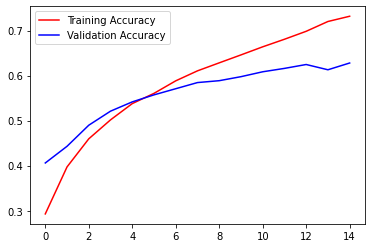

In [18]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

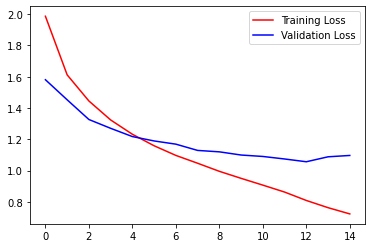

In [19]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

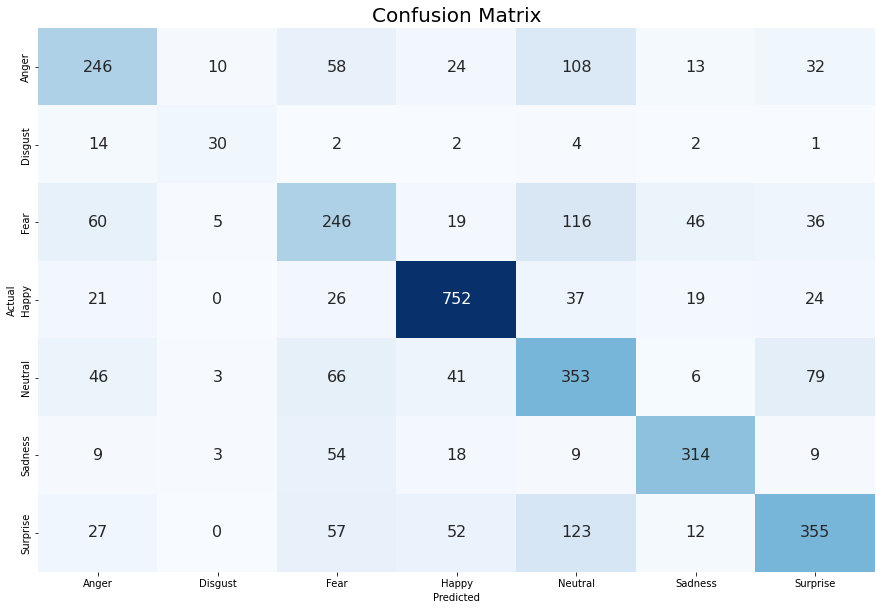

In [20]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [21]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.582     0.501     0.538       491
           1      0.588     0.545     0.566        55
           2      0.483     0.466     0.474       528
           3      0.828     0.856     0.842       879
           4      0.471     0.594     0.525       594
           5      0.762     0.755     0.758       416
           6      0.662     0.567     0.611       626

    accuracy                          0.640      3589
   macro avg      0.625     0.612     0.616      3589
weighted avg      0.644     0.640     0.640      3589

